## Fraud Detection
The goal of this case study is to use various classification-based models to detect whether a transaction is a normal payment or a fraud.


## 1. Problem definition

In the classification framework defined for this case study, the response variable takes
a value of 1 in case the given transaction is fraud and 0 otherwise.

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. The task is to get forecast the fraud. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise. The features are the result of PCA transformation and aren't intuitive as far as their names are concerned.


## 2. Loading data

In [2]:
# Load libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from keras.optimizers import SGD

#Libraries for Saving the Model
from pickle import dump
from pickle import load

In [ ]:
# load dataset (this is only a sample of the dataset!!!)
dataset = read_csv(r'C:\Users\roosd\Downloads\econometrie jaar 3\MIF course\creditcard_sample.csv')

# Disable the warnings
import warnings
warnings.filterwarnings('ignore')

## 3. Exploratory Data Analysis

In [6]:
dataset.shape

(99999, 31)

In [7]:
# peek at data
set_option('display.width', 100)
dataset.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
# types
set_option('display.max_rows', 500)
dataset.dtypes

Time        int64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

As shown in the results above, the entire data type is float, except Class which is integer, and the variable names aren't intuitive.

In [11]:
# describe data
pd.set_option('display.precision', 3)
dataset.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,99999.000,99999.000,99999.000,99999.000,99999.000,99999.000,99999.000,99999.000,99999.000,99999.000,...,99999.000,99999.000,99999.000,99999.000,99999.000,99999.000,1.000e+05,99999.000,99999.000,99999.000
mean,42432.982,-0.262,-0.032,0.676,0.163,-0.279,0.094,-0.109,0.056,-0.047,...,-0.031,-0.109,-0.037,0.009,0.132,0.027,6.058e-04,0.002,97.962,0.002
std,17044.825,1.859,1.657,1.323,1.349,1.356,1.301,1.211,1.208,1.121,...,0.719,0.634,0.633,0.595,0.441,0.495,3.937e-01,0.325,264.624,0.047
min,0.000,-56.408,-72.716,-33.681,-5.173,-42.148,-26.161,-31.765,-73.217,-9.284,...,-34.830,-10.933,-44.808,-2.837,-10.295,-2.534,-9.391e+00,-9.618,0.000,0.000
25%,33471.500,-1.028,-0.599,0.177,-0.711,-0.899,-0.648,-0.600,-0.137,-0.699,...,-0.225,-0.531,-0.176,-0.324,-0.132,-0.325,-6.253e-02,-0.005,7.570,0.000
50%,44299.000,-0.261,0.078,0.754,0.193,-0.314,-0.157,-0.069,0.074,-0.119,...,-0.058,-0.084,-0.049,0.065,0.170,-0.070,9.832e-03,0.023,26.310,0.000
75%,55851.000,1.153,0.736,1.376,1.032,0.250,0.486,0.415,0.361,0.558,...,0.119,0.308,0.082,0.406,0.420,0.301,8.302e-02,0.077,89.000,0.000
max,67374.000,1.960,18.902,4.226,16.716,34.802,22.529,36.677,20.007,10.393,...,22.615,10.503,19.003,4.014,5.542,3.517,1.215e+01,33.848,19656.530,1.000


Let us check the number of fraud vs. non-fraud cases in the data set.

In [12]:
class_names = {0:'Not Fraud', 1:'Fraud'}
print(dataset.Class.value_counts().rename(index = class_names))

Class
Not Fraud    99776
Fraud          223
Name: count, dtype: int64


The dataset is unbalanced with most of the transactions being non-fraud.

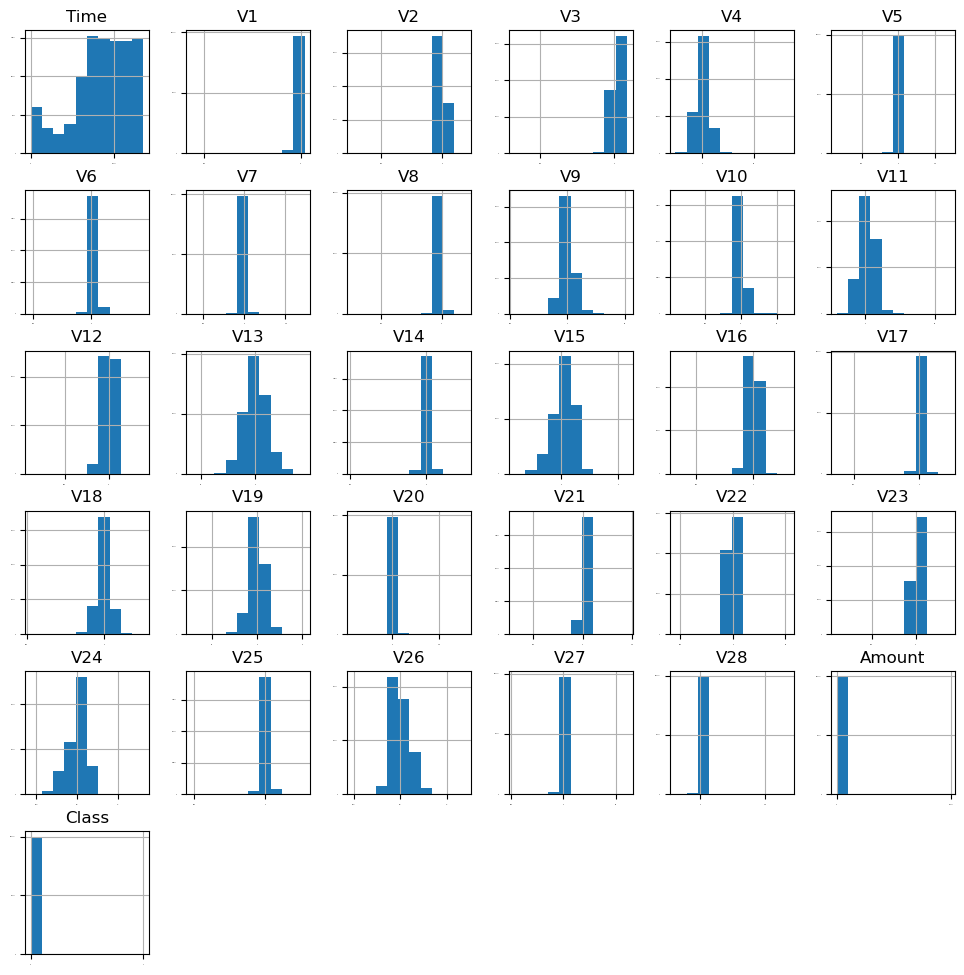

In [14]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

Distribution of most of the variables are highly skewed. However, given the variable names aren't known, we don't get much intuition from the plot.

## 4. Data preparation

In [15]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = False


There is no null in the data, and the data is already in the float format, so there is no need to clean or categorise the data

Feature selection:

In [16]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestfeatures = SelectKBest( k=10)
bestfeatures
Y= dataset["Class"]
X = dataset.loc[:, dataset.columns != 'Class']
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

   Specs      Score
17   V17  20657.815
14   V14  16227.609
3     V3  10383.969
12   V12   9644.180
10   V10   7909.706
16   V16   6829.653
7     V7   6157.564
11   V11   3567.597
4     V4   2840.800
18   V18   2632.037


Although some of the features are relevant, feature selection is not given significant preference.

## 5. Evaluate algorithms and models

Train, test, split

In [17]:
# split out validation dataset for the end
Y= dataset["Class"]
X = dataset.loc[:, dataset.columns != 'Class']
validation_size = 0.2
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)
scoring = 'accuracy'

Checking models and algorithms

In [18]:
# test options for classification
num_folds = 10
seed = 7

In [19]:
# spot check some basic Classification algorithms
#Given Data is huge, some of the slower classification algorithms are commented
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
#Neural Network
models.append(('NN', MLPClassifier()))
# #Ensable Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))

In [21]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.998362 (0.000313)
LDA: 0.999100 (0.000361)
KNN: 0.997925 (0.000363)
CART: 0.999150 (0.000325)
NB: 0.985125 (0.001548)
SVM: 0.997887 (0.000328)
NN: 0.997762 (0.000706)
AB: 0.999200 (0.000307)
GBM: 0.998800 (0.000708)
RF: 0.999562 (0.000245)
ET: 0.999562 (0.000258)


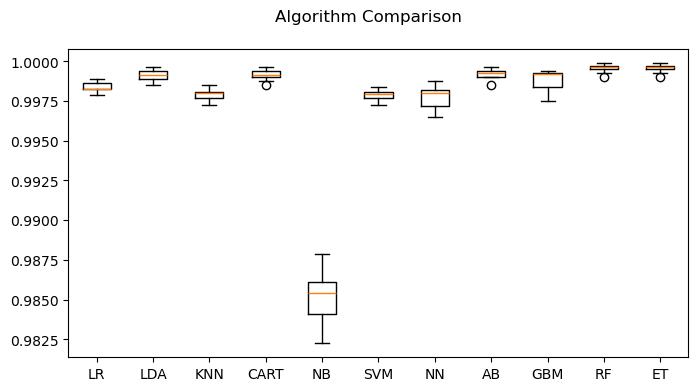

In [22]:
# compare algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(8,4)
pyplot.show()

The accuracy is very high, given that accuracy focusses on the overall no fraud case, but lets check how well it predicts the fraud case. Choosing one of the model CART from the results above

In [23]:
# prepare model
model = DecisionTreeClassifier()
model.fit(X_train, Y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [ ]:
""""
Recall=True positive / (True positive + False negative)
precision=True positive / (True positive + False positive)
"""

# estimate accuracy on validation set
#rescaledValidationX = scaler.transform(X_validation)
rescaledValidationX = X_validation
predictions = model.predict(rescaledValidationX)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.99895
[[19937     9]
 [   12    42]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19946
           1       0.82      0.78      0.80        54

    accuracy                           1.00     20000
   macro avg       0.91      0.89      0.90     20000
weighted avg       1.00      1.00      1.00     20000



<Axes: xlabel='Predicted', ylabel='Actual'>

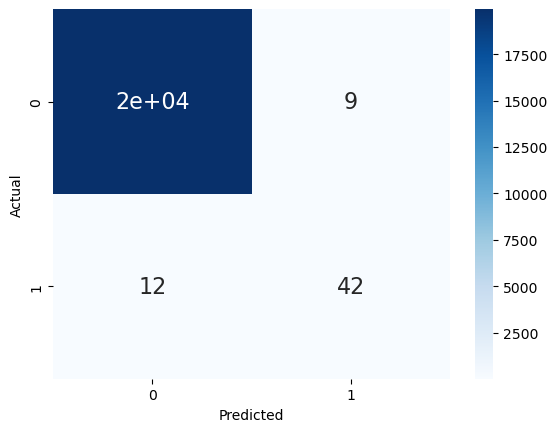

In [25]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

Although results are good, but still 12 out of 100 frauds aren't caught. So, we should focus on *recall*, which is a metric which minimises false negative. 

## 6. Model tuning

Evaluation Metric recall is selected, which is a metric which minimises false negative.

In [26]:
scoring = 'recall'

In [27]:
# spot check some basic Classification algorithms
#Given Data is huge, some of the slower classification algorithms are commented
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
# models.append(('NB', GaussianNB()))
# models.append(('SVM', SVC()))
# #Neural Network
# models.append(('NN', MLPClassifier()))
# # #Ensable Models 
# # Boosting methods
# models.append(('AB', AdaBoostClassifier()))
# models.append(('GBM', GradientBoostingClassifier()))
# # Bagging methods
# models.append(('RF', RandomForestClassifier()))
# models.append(('ET', ExtraTreesClassifier()))

In [29]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.545427 (0.118713)
LDA: 0.761890 (0.148240)
KNN: 0.020168 (0.044498)
CART: 0.804114 (0.092021)


Given the CART has the best recall out of all the models, it is used to evaluate the test set.

In [31]:
# prepare model
model = DecisionTreeClassifier(random_state=seed)
model.fit(X_train, Y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,7
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [32]:
# prepare model
model = DecisionTreeClassifier(random_state=seed)
model.fit(X_train, Y_train)

# estimate accuracy on validation set
rescaledValidationX = X_validation
predictions = model.predict(rescaledValidationX)
print("Accuracy:", accuracy_score(Y_validation, predictions))
print("\nConfusion Matrix:")
print(confusion_matrix(Y_validation, predictions))
print("\nClassification Report:")
print(classification_report(Y_validation, predictions))

Accuracy: 0.9991

Confusion Matrix:
[[19938     8]
 [   10    44]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19946
           1       0.85      0.81      0.83        54

    accuracy                           1.00     20000
   macro avg       0.92      0.91      0.91     20000
weighted avg       1.00      1.00      1.00     20000



<Axes: xlabel='Predicted', ylabel='Actual'>

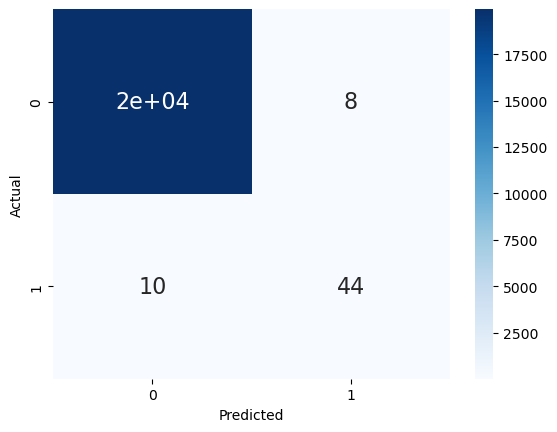

In [33]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

CART performs better with only 10 out of cases of fraud not caught. Additionally, false positives are less as well.
However, there are still 10 fraud cases in the test set which aren't caught. This will be further taken care in the following section.

<a id='5.2'></a>
## 6.2. Model Tuning for balancing the sample by Random Under Sampling
In this phase of the project we will implement "Random Under Sampling" which basically consists of removing data in order to have a more balanced dataset and thus avoiding our models to overfitting.

Steps:
1. The first thing we have to do is determine how imbalanced is our class (use "value_counts()" on the class column to determine the amount for each label)
2. Once we determine how many instances are considered fraud transactions (Fraud = "1") , we should bring the non-fraud transactions to the same amount as fraud transactions (assuming we want a 50/50 ratio), this will be equivalent to 223 cases of fraud and 223 cases of non-fraud transactions.
3. After implementing this technique, we have a sub-sample of our dataframe with a 50/50 ratio with regards to our classes. Then the next step we will implement is to shuffle the data to see if our models can maintain a certain accuracy everytime we run this script.

Note: The main issue with "Random Under-Sampling" is that we run the risk that our classification models will not perform as accurate as we would like to since there is a great deal of information loss (bringing 223 non-fraud transaction from 99776 non-fraud transaction)


In [34]:
Y_train.head()

91525    0
19416    0
99078    0
45086    0
54659    0
Name: Class, dtype: int64

Distribution of the Classes in the subsample dataset
Class
0    223
1    223
Name: count, dtype: int64


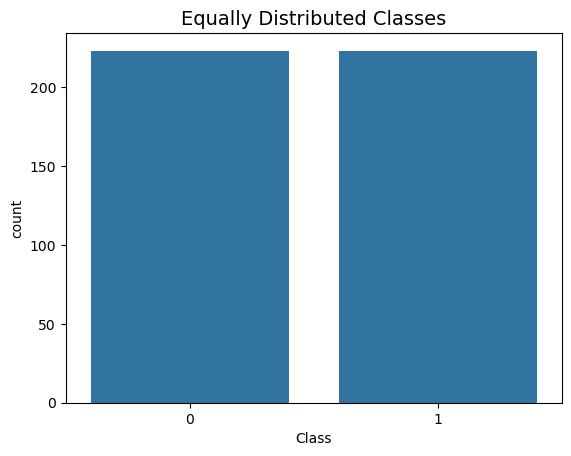

In [42]:
# START WITH THE FULL DATASET (before train_test_split)
# Separate features and target
X_full = dataset.drop('Class', axis=1)
Y_full = dataset['Class']

# Create combined dataframe
df_full = pd.concat([X_full, Y_full], axis=1)

# Undersample
fraud_df = df_full.loc[df_full['Class'] == 1]  # All 223 fraud cases
non_fraud_df = df_full.loc[df_full['Class'] == 0][:223]  # 223 non-fraud cases

# Combine and shuffle
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])
df_new = normal_distributed_df.sample(frac=1, random_state=42)

# NOW split into X and Y
Y_new = df_new['Class']
X_new = df_new.drop('Class', axis=1)

# Check distribution
print('Distribution of the Classes in the subsample dataset')
print(Y_new.value_counts())
sns.countplot(x='Class', data=df_new)
pyplot.title('Equally Distributed Classes', fontsize=14)
pyplot.show()

# THEN do train/test split on the balanced data
X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y_new, test_size=0.2, random_state=42)

Now that we have our dataframe correctly balanced, we can go further with our analysis and data preprocessing.
Given the total number of data points are around 500, we try all the Models including Deep Learning Models. 
However, given the data is balanced, the metric used here is accuracy, as it focuses on both false positive and false negative. 

In [51]:
scoring='accuracy'
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
#Neural Network
models.append(('NN', MLPClassifier()))
# #Ensable Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))

In [52]:
EnableDLModelsFlag = 1
if EnableDLModelsFlag == 1:   
    def create_model(neurons=12, activation='relu'):
        model = Sequential()
        model.add(Dense(X_train_new.shape[1], input_dim=X_train_new.shape[1], activation=activation))
        model.add(Dense(32, activation=activation))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model    
    models.append(('DNN', KerasClassifier(model=create_model, epochs=50, batch_size=10, verbose=0)))

In [53]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train_new, Y_train_new, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.959167 (0.038370)
LDA: 0.923397 (0.040957)
KNN: 0.640256 (0.065701)
CART: 0.926090 (0.047612)
NB: 0.936218 (0.030856)
SVM: 0.599295 (0.083413)
NN: 0.614359 (0.201696)
AB: 0.956667 (0.028140)
GBM: 0.951667 (0.034857)
RF: 0.956603 (0.030455)
ET: 0.956603 (0.034504)
DNN: 0.721603 (0.165178)


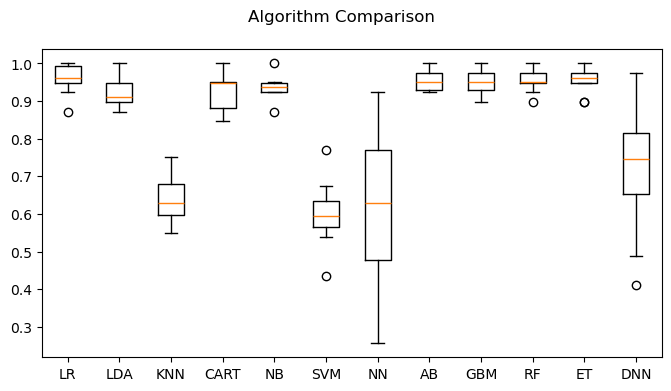

In [54]:
# compare algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(8,4)
pyplot.show()

Given that GBM is the best model out of all the models, a grid search is performed for GBM model by varing number of estimators and maximum depth. 

In [56]:
# Grid Search: GradientBoosting Tuning
'''
n_estimators : int (default=100)
    The number of boosting stages to perform. 
    Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
max_depth : integer, optional (default=3)
    maximum depth of the individual regression estimators. 
    The maximum depth limits the number of nodes in the tree. 
    Tune this parameter for best performance; the best value depends on the interaction of the input variables.

''' 
n_estimators = [20,180,1000]
max_depth= [2, 3,5]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)
model = GradientBoostingClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train_new, Y_train_new)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.956667 using {'max_depth': 2, 'n_estimators': 1000}
#6 0.941346 (0.037888) with: {'max_depth': 2, 'n_estimators': 20}
#2 0.954167 (0.033829) with: {'max_depth': 2, 'n_estimators': 180}
#1 0.956667 (0.034349) with: {'max_depth': 2, 'n_estimators': 1000}
#5 0.941410 (0.040949) with: {'max_depth': 3, 'n_estimators': 20}
#3 0.949103 (0.035907) with: {'max_depth': 3, 'n_estimators': 180}
#3 0.949103 (0.035907) with: {'max_depth': 3, 'n_estimators': 1000}
#8 0.931282 (0.046721) with: {'max_depth': 5, 'n_estimators': 20}
#6 0.941346 (0.042930) with: {'max_depth': 5, 'n_estimators': 180}
#9 0.931090 (0.048739) with: {'max_depth': 5, 'n_estimators': 1000}


0.9669
[[19290   656]
 [    6    48]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     19946
           1       0.07      0.89      0.13        54

    accuracy                           0.97     20000
   macro avg       0.53      0.93      0.55     20000
weighted avg       1.00      0.97      0.98     20000



<Axes: xlabel='Predicted', ylabel='Actual'>

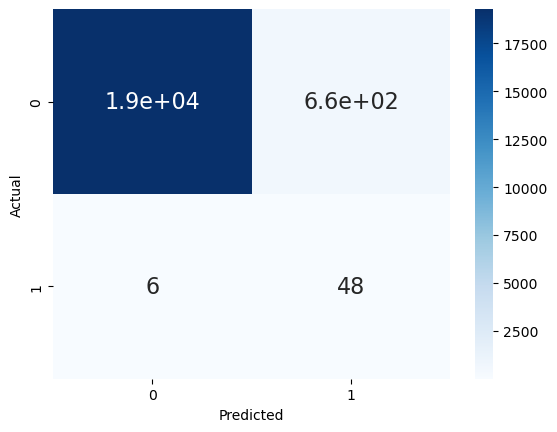

In [57]:
# prepare model
model = GradientBoostingClassifier(max_depth= 5, n_estimators = 1000)
model.fit(X_train_new, Y_train_new)

# estimate accuracy on Original validation set
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

The results on the test set are really good and the model performs much better with no case of fraud not caught. 

__Conclusion__:

Choosing the right metric lead to an 
enhancement in the fraud cases detected correctly. Under-sampling lead to a significant improvement as all the fraud cases in the test set are correctly identified post under-sampling. 

Under-sampling came with a tradeoff though. In the under-sampled
data our model is unable to detect for a large number of cases non-fraud transactions correctly and instead, misclassifies those non-fraud transactions as fraud cases. 
